# Import Module

In [1]:
import torch
import glob
import warnings
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 40,
     'BATCH_SIZE' : 64,
     'LR' : 0.00001,
     'model_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Histogram_Equalization.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [12]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"/home/user1/바탕화면/HJ/AICOSS_2023(Pnuemonia)/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"/home/user1/바탕화면/HJ/AICOSS_2023(Pnuemonia)/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [13]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [14]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

# Normal / Virus 데이터가 Bacteria의 절반밖에 안된다 -> augmentation으로 data imbalance를 잡는다
train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

In [15]:
# 이미지 크기: (224,224)로 변환 [훈련/테스트 모두]
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

aug_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

# Make Dataset

In [16]:
# Crop Dataset 만들기
# Crop: 이미지에서 불순물 제거 (완전히 제거하지는 못함, 테두리에 낀 불순물만)
class Cropdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.85 * w)  # 가로 길이로는 조금 더 crop 해보기 (쓸데 없는 뼈는 학습하지 않도록)
    
        if dimension == 2:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w]
        else:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w, :]
    
        return cropped_image  # ndarray 반환

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)  # ndarray 반환
        img = self.__crop__(img)  # ndarray 반환
        R = cv2.equalizeHist(img[:, :, 0])
        G = cv2.equalizeHist(img[:, :, 1])
        B = cv2.equalizeHist(img[:, :, 2])
        img = PIL.Image.fromarray(cv2.merge((R, G, B)))

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(label)

In [17]:
train_crop_dataset = Cropdataset(train_data, train_label, train_transform)  # t_c_dataset: [IMAGE, LABEL]
train_aug_dataset = Cropdataset(train_aug, train_aug_label, aug_transform)  # t_a_dataset: [IMAGE, LABEL]
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [14]:
img, label = next(iter(train_dataloader))

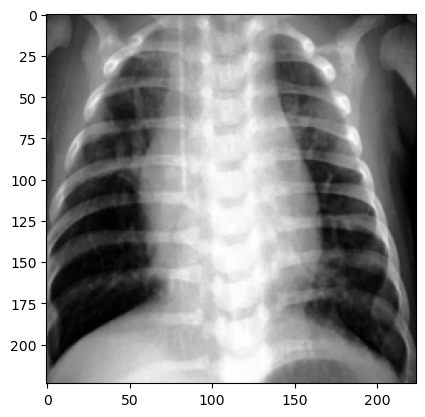

In [15]:
# len(train_dataloader.dataset)  # 7902개의 이미지
from torchvision.transforms.functional import to_pil_image
sample = to_pil_image(img[15])
plt.imshow(sample)

In [16]:
print(f"Image shape : {img[0].shape}")
print(f"Left Image Shape : {label[0].shape}")

Image shape : torch.Size([3, 224, 224])
Left Image Shape : torch.Size([3])


# Define Model

In [21]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x

In [22]:
model = Model()
model = nn.DataParallel(model).to(device)
model

DataParallel(
  (module): Model(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

# Define Loss, Optimizer

In [23]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

# Training

In [20]:
def train_loop(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)  # 124 batches in 1 epoch
    datasize = len(dataloader.dataset)  # 7902 images in total

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 30 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [20]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, CFG['model_save_path'])

Start epoch : 1
Batch loss : 1.09884 0/124
Batch loss : 1.09905 30/124
Batch loss : 1.09722 60/124
Batch loss : 1.09088 90/124
Batch loss : 1.08993 120/124
Loss : 1.09580 ACC : 39.99%
End epoch : 1
Epoch time : 3.0 min 29.80228900909424 sec

Start epoch : 2
Batch loss : 1.09136 0/124
Batch loss : 1.09347 30/124
Batch loss : 1.08901 60/124
Batch loss : 1.08589 90/124
Batch loss : 1.08185 120/124
Loss : 1.08754 ACC : 53.64%
End epoch : 2
Epoch time : 3.0 min 17.775277137756348 sec

Start epoch : 3
Batch loss : 1.08367 0/124
Batch loss : 1.07631 30/124
Batch loss : 1.07707 60/124
Batch loss : 1.06813 90/124
Batch loss : 1.05390 120/124
Loss : 1.07380 ACC : 57.72%
End epoch : 3
Epoch time : 3.0 min 20.52312731742859 sec

Start epoch : 4
Batch loss : 1.06535 0/124
Batch loss : 1.05240 30/124
Batch loss : 1.04504 60/124
Batch loss : 1.03978 90/124
Batch loss : 1.00295 120/124
Loss : 1.04416 ACC : 58.42%
End epoch : 4
Epoch time : 3.0 min 17.22071647644043 sec

Start epoch : 5
Batch loss : 1.

In [38]:
model.load_state_dict(torch.load(CFG['model_save_path']))
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, "/home/user1/바탕화면/HJ/Codes/Histogram_Equalization_Continued(40 epochs).pt")

Start epoch : 1
Batch loss : 0.59059 0/124
Batch loss : 0.63208 30/124
Batch loss : 0.61842 60/124
Batch loss : 0.57077 90/124
Batch loss : 0.58555 120/124
Loss : 0.61157 ACC : 94.75%
End epoch : 1
Epoch time : 3.0 min 21.852824449539185 sec

Start epoch : 2
Batch loss : 0.59611 0/124
Batch loss : 0.61254 30/124
Batch loss : 0.62228 60/124
Batch loss : 0.60169 90/124
Batch loss : 0.58812 120/124
Loss : 0.60753 ACC : 95.19%
End epoch : 2
Epoch time : 3.0 min 22.390536308288574 sec

Start epoch : 3
Batch loss : 0.57405 0/124
Batch loss : 0.59303 30/124
Batch loss : 0.62194 60/124
Batch loss : 0.58269 90/124
Batch loss : 0.61360 120/124
Loss : 0.60335 ACC : 95.51%
End epoch : 3
Epoch time : 3.0 min 18.917837142944336 sec

Start epoch : 4
Batch loss : 0.61698 0/124
Batch loss : 0.56433 30/124
Batch loss : 0.58298 60/124
Batch loss : 0.60171 90/124
Batch loss : 0.58190 120/124
Loss : 0.60230 ACC : 95.53%
End epoch : 4
Epoch time : 3.0 min 18.772306442260742 sec

Start epoch : 5
Batch loss :

Text(0.5, 1.0, 'Train Loss')

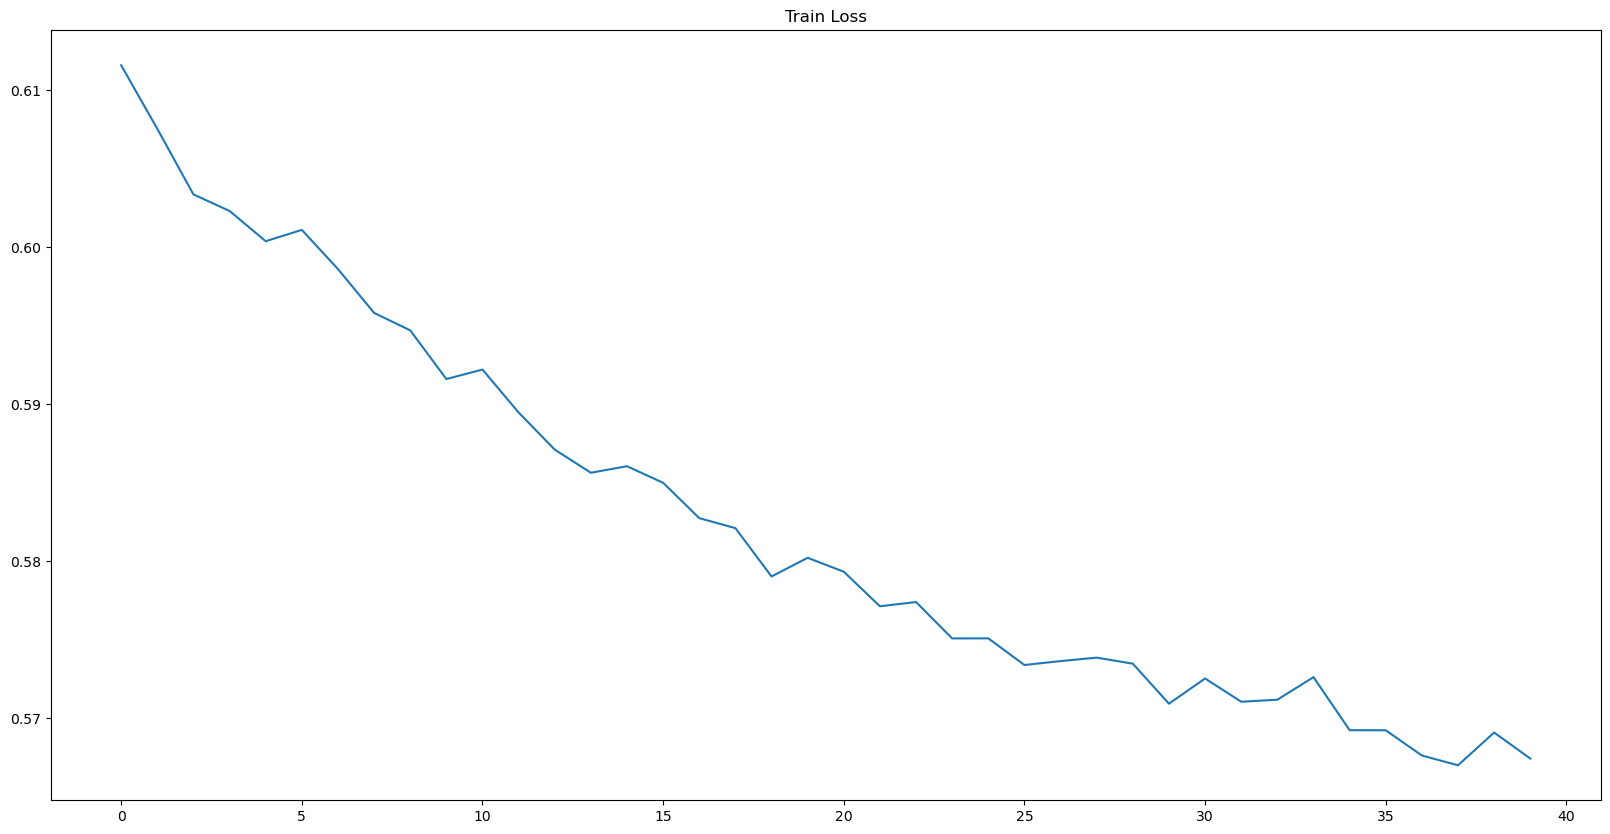

In [39]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

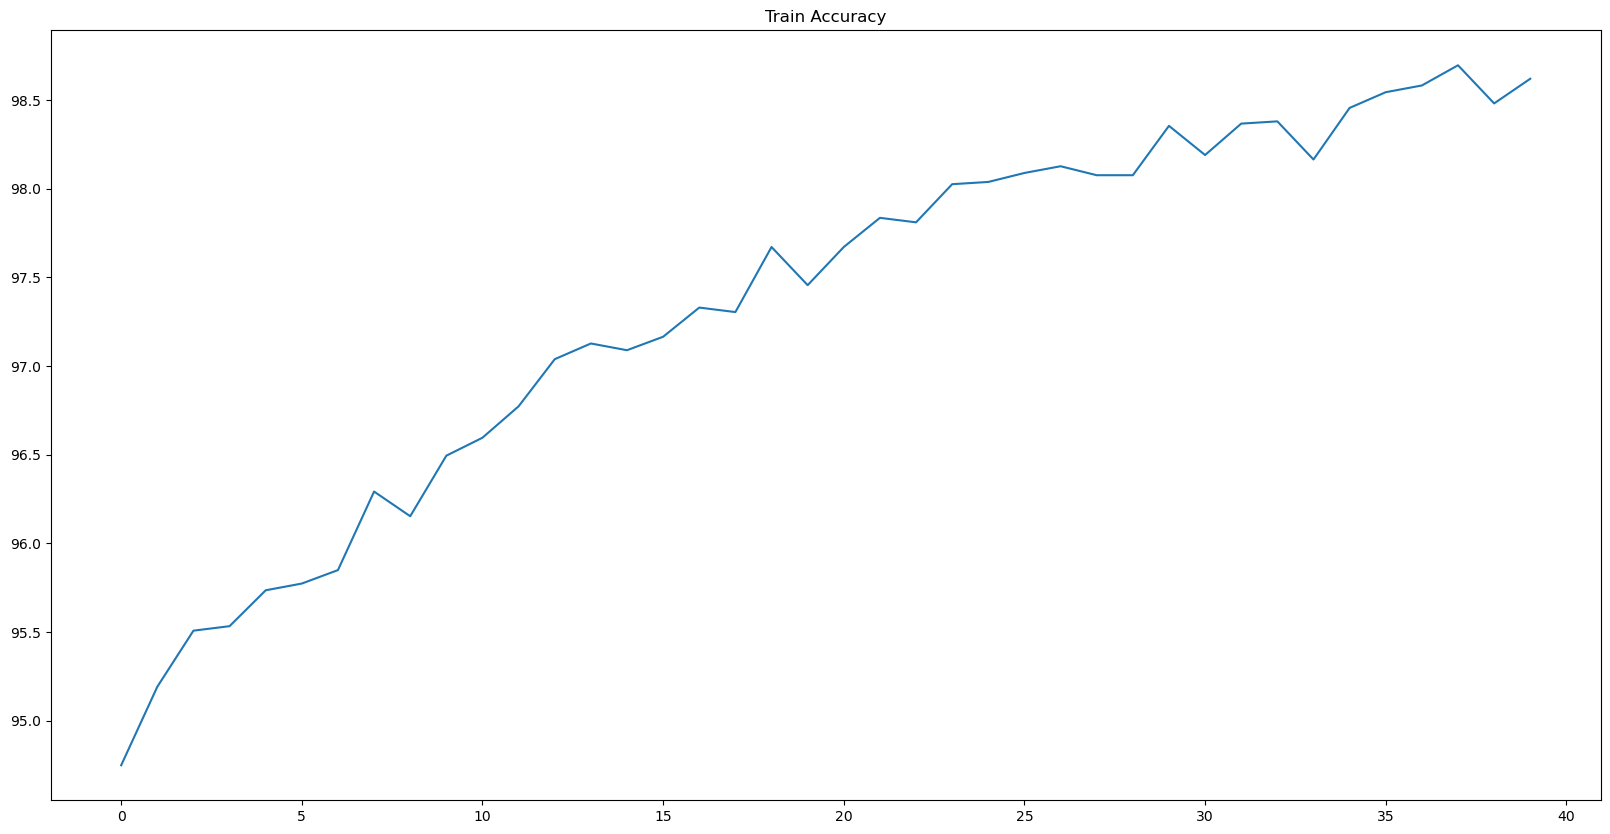

In [40]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')

# TEST

In [18]:
test_crop_dataset = Cropdataset(test_data, test_label, test_transform)  # [IMAGE, LABEL]
test_aug_dataset = Cropdataset(test_vir, test_vir_label, aug_transform)  # [IMAGE, LABEL]
test_dataset = test_crop_dataset + test_aug_dataset
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [24]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (X, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output = model(X)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [27]:
label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, label, pred  = test_loop(test_dataloader, model, "/home/user1/바탕화면/HJ/AICOSS_2023(Pnuemonia)/Histogram_Equalization.pt")

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

In [29]:
OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

<Axes: >

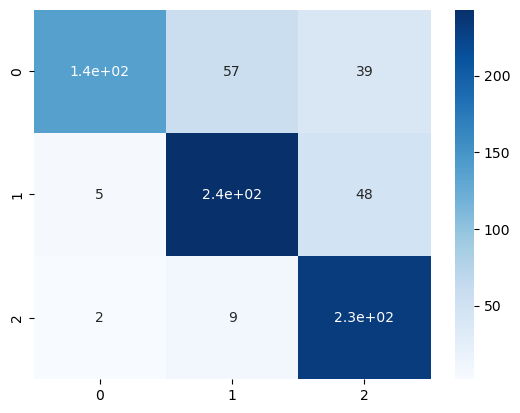

In [30]:
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [31]:
def correct_count(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_correct = 0
    v_correct = 0
    b_correct = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if (pred_idx == label_idx):
            if pred_idx == 0:  # Normal
                n_correct += 1
            elif pred_idx == 1:  # Virus
                v_correct += 1
            elif pred_idx == 2:  # Bacteria
                b_correct += 1
    
    return n_correct, v_correct, b_correct

In [32]:
def nvb_size(label):
    total = len(label)
    total_n = 0
    total_v = 0
    total_b = 0

    for idx in range(total):
        now = label[idx]
        if now[0] == 1:
            total_n += 1
        elif now[1] == 1:
            total_v += 1
        elif now[2] == 1:
            total_b += 1
        
    return total_n, total_v, total_b

In [33]:
total_n, total_v, total_b = nvb_size(label)
n_correct, v_correct, b_correct = correct_count(pred, label)

total = total_n + total_v + total_b
total_correct = n_correct + v_correct + b_correct

print(f"Normal Sensitivity: {n_correct/total_n}")
print(f"Virus Sensitivity: {v_correct/total_v}")
print(f"Bacteria Sensitivity: {b_correct/total_b}\n")
print(f"Test Accuracy: {total_correct/total}")

Normal Sensitivity: 0.5897435897435898
Virus Sensitivity: 0.8209459459459459
Bacteria Sensitivity: 0.9545454545454546

Test Accuracy: 0.7927461139896373


In [34]:
def calc_spec(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_FP = 0
    v_FP = 0
    b_FP = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if pred_idx == 0 and label_idx != 0:
            n_FP += 1
        elif pred_idx == 1 and label_idx != 1:
            v_FP += 1
        elif pred_idx == 2 and label_idx != 2:
            b_FP += 1
        
    n_TN = total - total_n - n_FP
    v_TN = total - total_v - v_FP
    b_TN = total - total_b - b_FP

    n_spec = n_TN/(n_TN + n_FP)
    v_spec = v_TN/(v_TN + v_FP)
    b_spec = b_TN/(b_TN + b_FP)
    
    return n_spec, v_spec, b_spec

In [35]:
n_spec, v_spec, b_spec = calc_spec(pred, label)

print(f"Normal Specificity: {n_spec}")
print(f"Virus Specificity: {v_spec}")
print(f"Bacteria Specificity: {b_spec}\n")

Normal Specificity: 0.9869888475836431
Virus Specificity: 0.8613445378151261
Bacteria Specificity: 0.8358490566037736

